In [1]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd

df = pd.read_csv("../experiments/data/interim/DIJA-2006-2018-clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
df.head()

,Open,High,Low,Close,Name
Date,,,,,
2006-01-03,77.76,79.35,77.24,79.11,MMM
2006-01-04,79.49,79.49,78.25,78.71,MMM
2006-01-05,78.41,78.65,77.56,77.99,MMM
2006-01-06,78.64,78.90,77.64,78.63,MMM
2006-01-09,78.50,79.83,78.46,79.02,MMM


In [53]:
from hedgepy.core import HedgeFrame

hf = HedgeFrame(df, 'Name')
_30d_dcor_network = hf.dcor(rolling_window=30).network().frame

In [54]:
import networkx as nx 

nx_time_series = {
    timestamp: nx.average_clustering(dcor_network, weight='weight') 
     for timestamp, dcor_network in _30d_dcor_network.items()
}
    
df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
    .rename(columns={0: '30d_global_clustering_coefficient'})

In [55]:
df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-30d-dcor-nx-clustering.csv')

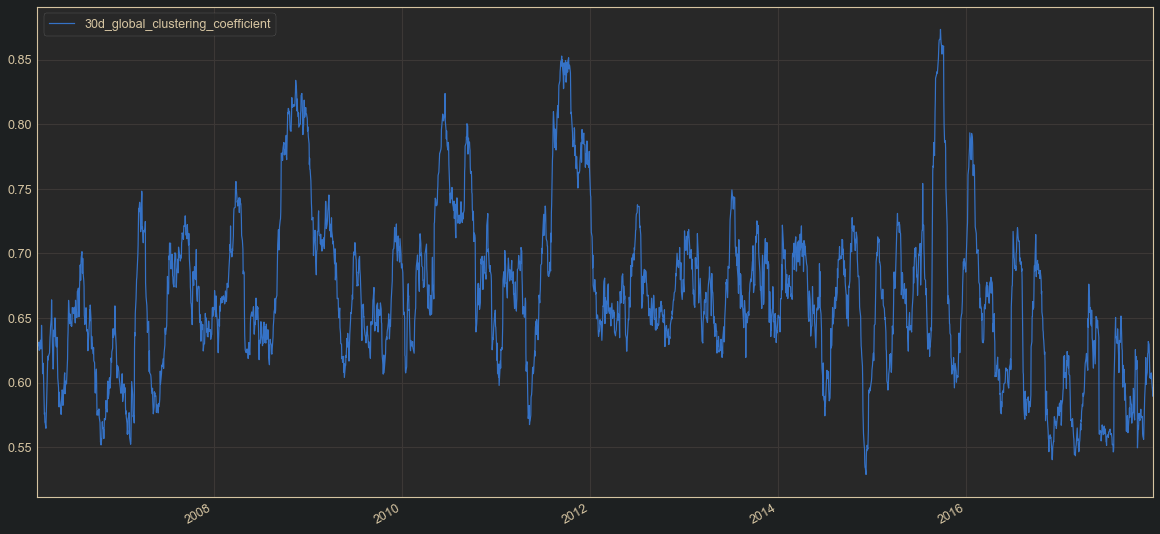

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

df_clustering.plot(figsize=(20,10))

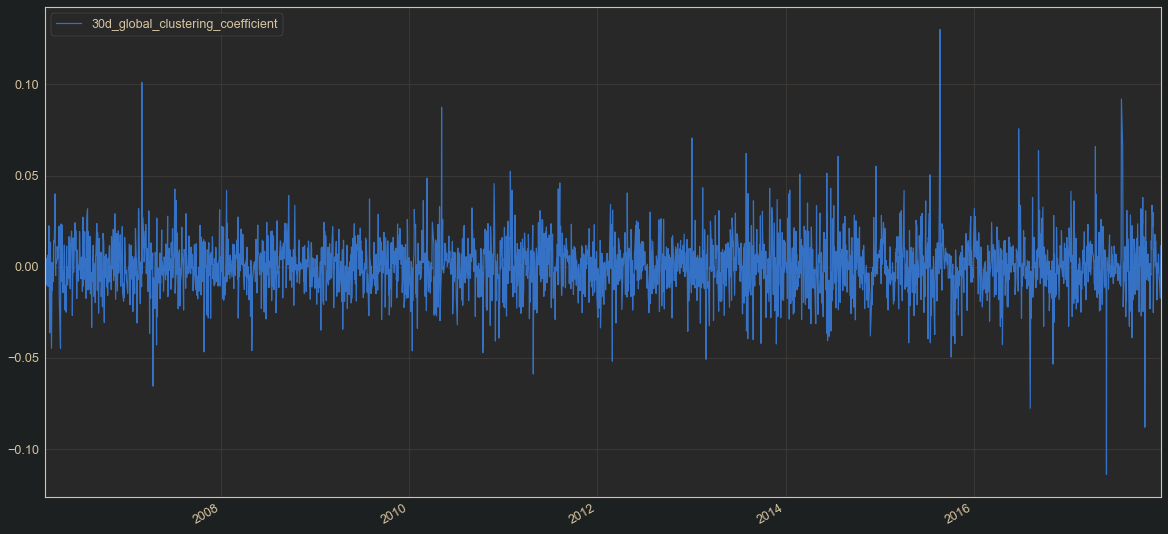

In [57]:
df_clustering.pct_change().plot(figsize=(20,10))

Text(0, 0.5, 'DIJA Index')

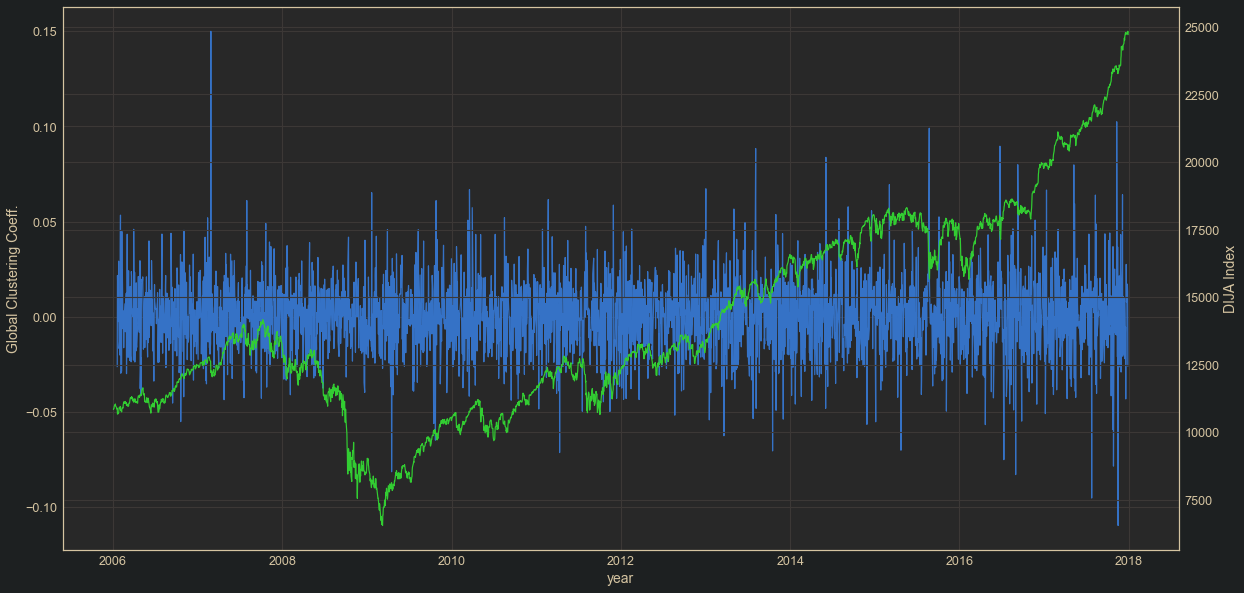

In [50]:
# df_clustering.pct_change().plot(figsize=(20,10))
# df_final['Close'].plot()

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_clustering.pct_change())
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [52]:
df_clustering.pct_change()[df_clustering.pct_change()['90d_global_clustering_coefficient'] == df_clustering.pct_change().max()[0]]

,90d_global_clustering_coefficient
2007-02-27,0.150024


In [6]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [7]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [8]:
df_dija_index.set_index('Date', inplace=True)

In [33]:
df_final = df_clustering.merge(df_dija_index, left_index=True, right_index=True)

In [34]:
df_final.head()

,90d_global_clustering_coefficient,Open,High,Low,Close,Adj Close,Volume
2006-05-12,0.444310,11500.00977,11500.00977,11374.74023,11380.99023,11380.99023,321240000
2006-05-15,0.440983,11380.42969,11435.33984,11333.04004,11428.76953,11428.76953,300550000
2006-05-16,0.443014,11428.20996,11460.54981,11392.66992,11419.88965,11419.88965,307170000
2006-05-17,0.446978,11410.12988,11410.12988,11174.37988,11205.61035,11205.61035,399460000
2006-05-18,0.444304,11206.16992,11247.38965,11127.08984,11128.29004,11128.29004,338300000


In [35]:
import ipyhc as hc

dija_index_series = hc.build.series(df_final[['Close']])
df_clustering_series = hc.build.series(df_final[['90d_global_clustering_coefficient']])

In [36]:
df_clustering_series[0]['yAxis'] = 1

In [42]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=700, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='700px', stock=True, width='1200px')